recalculating on signali3 data, also including eqi original recalculation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shap

```
Inputs to the device are: dotok, pretok, kisik.
dotok: t(d), Q(m3/d), T(C), COD(g/m3), NH4(g/m3), TN(g/m3), TSS(g/m3), TP(g /m3)
pretok: time(d),Qintr(m3/d),Qr(m3/d), Qw(m3/d), Quprimary(m3/d),Quthickener(m3/d),Qodewatering(m3/d ),Qmetal(m3/d)
kisik: t(d), DO5(g/m3), DO6(g/m3), DO6ref, DO7(g/m3)

Outputs from the device are: iztok, kvaliteta, stroski.
iztok: t(d), Q(m3/d), COD(g/m3), NH4(g/m3), TN(g/m3), TSS(g/m3), TP(g/m3) 
kvaliteta: t(d),EQI(kgPU/d)
stroski: t(d), SC, AE, PE, ME, OCI 

```

```
t is time, 
Q is flow, 
T is water temperature, 
COD organic matter (COD), 
NH4 ammonium nitrogen, 
TN total nitrogen, 
TSS insoluble matter (sludge), 
TP Total Phosphorus
```

In [2]:
df_inflow = pd.read_csv('signali3/dotok.txt', sep="   ", header=None, engine="python")
df_inflow.columns = ['t', 'Qi', 'T', 'CODi', 'NH4i', 'TNi', 'TSSi', 'TPi']
df_inflow

,t,Qi,T,CODi,NH4i,TNi,TSSi,TPi
0,0.000000,15307.639,19.778256,618.68767,19.385486,44.366623,355.15754,7.664431
1,0.010417,14574.938,19.751569,618.19231,19.493344,44.514921,356.50810,7.894627
2,0.020833,14070.151,19.723738,614.27099,19.178030,44.106520,355.64635,8.148740
3,0.031250,13672.401,19.694886,607.83669,18.550334,43.286466,353.12471,8.417167
4,0.041667,13321.633,19.665137,600.35155,17.787845,42.288617,349.87310,8.694293
...,...,...,...,...,...,...,...,...
34939,363.947920,14235.764,19.890695,726.49109,25.728374,55.309016,426.44843,12.570848
34940,363.958330,13465.486,19.871345,733.16851,26.113640,56.017687,431.91839,12.590570
34941,363.968750,12846.759,19.850331,738.37887,26.457572,56.627340,436.58317,12.569712
34942,363.979170,12472.014,19.827745,736.44633,26.447194,56.613192,437.56535,12.377426


```
Qintr Internal Recycle Flow, 
Qr External Recycle Flow, 
Qw Excess Sludge Flow, 
QuPrimary Sludge Flow from Primary Settler, 
Quthickener Sludge Flow from Thickener, 
Qodewatering Sludge Flow from Dehydrator, 
```

In [3]:
df_flow = pd.read_csv('signali3/pretok.txt', sep="   ", header=None, engine="python")
df_flow.columns = ['t', 'Qintr', 'Qr', 'Qw', 'Quprimary', 'Quthickener', 'Qodewatering', 'Qmetal']
df_flow.set_index('t', inplace=True)
df_flow

,Qintr,Qr,Qw,Quprimary,Quthickener,Qodewatering,Qmetal
t,,,,,,,
0.000000,48134.831,25411.192,476.45151,138.91475,27.938329,169.76770,0.099409
0.010417,48134.831,25411.192,476.45151,138.91475,27.931327,169.30621,0.099409
0.020833,48134.831,25411.192,476.45151,138.91475,27.925170,168.81797,0.099409
0.031250,48134.831,25411.192,476.45151,138.91475,27.919964,168.32648,0.099409
0.041667,48134.831,25411.192,476.45151,138.91475,27.915775,167.85111,0.099409
...,...,...,...,...,...,...,...
363.947920,66247.012,28275.330,614.56807,142.12851,27.574580,179.31629,0.100824
363.958330,66247.012,28275.330,614.56807,142.12851,27.565786,178.73916,0.100824
363.968750,66247.012,28275.330,614.56807,142.12851,27.557369,178.14462,0.100824


```
DO5 Oxygen in Pool 5, 
DO6 Oxygen in Pool 6
DO6ref oxygen set-point in pool 6, 
DO7 oxygen in pool 7, 

```

In [4]:
df_oxygen = pd.read_csv('signali3/kisik.txt', sep="   ", header=None, engine="python")
df_oxygen.columns = ['t', 'DO5', 'DO6', 'DO6ref', 'DO7']
df_oxygen.set_index('t', inplace=True)
df_oxygen

,DO5,DO6,DO6ref,DO7
t,,,,
0.000000,0.421619,1.885546,1.862446,1.652671
0.010417,0.414774,1.886476,1.862446,1.615983
0.020833,0.408623,1.886378,1.862446,1.575264
0.031250,0.403533,1.885755,1.862446,1.532082
0.041667,0.399439,1.884909,1.862446,1.487742
...,...,...,...,...
363.947920,0.571230,2.004188,1.974689,1.790938
363.958330,0.560433,2.002997,1.974689,1.755976
363.968750,0.551338,2.001302,1.974689,1.718930


In [5]:
df_outflow = pd.read_csv('signali3/iztok.txt', sep="   ", header=None, engine="python")
df_outflow.columns = ['t' ,'Qo', 'CODo', 'NH4o', 'TNo', 'TSSo', 'TPo']
df_outflow['t'] = df_inflow['t']
df_inflow.set_index('t', inplace=True)
df_outflow.set_index('t', inplace=True)

In [6]:
df_outflow

,Qo,CODo,NH4o,TNo,TSSo,TPo
t,,,,,,
0.000000,15310.074,40.747287,0.134206,8.547754,12.446315,1.151249
0.010417,14574.638,40.562989,0.134080,8.554336,12.214636,1.124317
0.020833,14065.519,40.397727,0.133868,8.561917,12.003069,1.099661
0.031250,13665.758,40.259636,0.133560,8.570511,11.819984,1.077628
0.041667,13314.130,40.148434,0.133149,8.579520,11.664954,1.058173
...,...,...,...,...,...,...
363.947920,14236.261,40.616090,0.148899,9.372274,11.866729,1.226980
363.958330,13464.764,40.430510,0.149850,9.360392,11.648107,1.203165
363.968750,12843.180,40.257301,0.150506,9.350149,11.443239,1.181034


```
EQI effluent quality
```

In [7]:
df_quality = pd.read_csv('signali3/kvaliteta.txt', sep="   ", header=None, engine="python")
df_quality.columns = ['t', 'EQI']
df_quality.set_index('t', inplace=True)

```
SC sludge costs, 
AE aeration costs, 
PE pump costs, 
ME methane production, 
OCI operating costs
```

In [8]:
df_cost = pd.read_csv('signali3/stroski.txt', sep="   ", header=None, engine="python")
df_cost.columns = ['t', 'SC', 'AE', 'PE', 'ME', 'OCI']
df_cost.set_index('t', inplace=True)

In [9]:
df = pd.concat([df_inflow, df_flow, df_oxygen, df_outflow, df_quality, df_cost], axis=1)

In [10]:
df = df.reset_index()

In [11]:
df

,t,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,...,NH4o,TNo,TSSo,TPo,EQI,SC,AE,PE,ME,OCI
0,0.000000,15307.639,19.778256,618.68767,19.385486,44.366623,355.15754,7.664431,48134.831,25411.192,...,0.134206,8.547754,12.446315,1.151249,6784.3018,12186.282,4089.0169,864.85083,5479.8562,18632.809
1,0.010417,14574.938,19.751569,618.19231,19.493344,44.514921,356.50810,7.894627,48134.831,25411.192,...,0.134080,8.554336,12.214636,1.124317,6708.5149,12151.851,3985.6073,864.84630,5481.1852,18493.634
2,0.020833,14070.151,19.723738,614.27099,19.178030,44.106520,355.64635,8.148740,48134.831,25411.192,...,0.133868,8.561917,12.003069,1.099661,6639.6082,12115.332,3881.2010,864.84165,5482.3588,18351.531
3,0.031250,13672.401,19.694886,607.83669,18.550334,43.286466,353.12471,8.417167,48134.831,25411.192,...,0.133560,8.570511,11.819984,1.077628,6579.1221,12078.455,3779.0888,864.83710,5483.3568,18211.539
4,0.041667,13321.633,19.665137,600.35155,17.787845,42.288617,349.87310,8.694293,48134.831,25411.192,...,0.133149,8.579520,11.664954,1.058173,6526.8002,12042.626,3680.3567,864.83279,5484.2662,18076.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34939,363.947920,14235.764,19.890695,726.49109,25.728374,55.309016,426.44843,12.570848,66247.012,28275.330,...,0.148899,9.372274,11.866729,1.226980,7084.9219,13157.130,4290.8347,1069.90090,5703.9865,19871.296
34940,363.958330,13465.486,19.871345,733.16851,26.113640,56.017687,431.91839,12.590570,66247.012,28275.330,...,0.149850,9.360392,11.648107,1.203165,7012.8596,13113.850,4166.1694,1069.89530,5705.8772,19701.454
34941,363.968750,12846.759,19.850331,738.37887,26.457572,56.627340,436.58317,12.569712,66247.012,28275.330,...,0.150506,9.350149,11.443239,1.181034,6945.8375,13069.086,4048.2374,1069.88950,5707.8860,19536.743
34942,363.979170,12472.014,19.827745,736.44633,26.447194,56.613192,437.56535,12.377426,66247.012,28275.330,...,0.150881,9.341653,11.262719,1.161120,6886.0335,13024.240,3938.9908,1069.88380,5709.7644,19380.767


In [12]:
df['EQI_original'] = df.EQI * df.Qo / np.mean(df.Qo)

Sampling time is 0.01 d

Qintr, Qw, Qr, DO6ref vary randomly around preset values (+/- 10%).

We are interested in relations between inputs and outputs. Namely, we want to make a decision tree model for EQI(kgPU/d) and OCI primarily. It will be fine if you make a comparison between several models made with different algorithms - random forests, SVM, NN, etc. You can try it yourself first, and then we can meet on Zoom to see how you are doing and how to continue.

We are interested in feature engineering. This step consists of extracting a relevant feature subset to be used as input for models in further stages. You may use the ReliefF algorithm to select the variables that have the most influence on the results, which are compared using accuracy.


### Data preparation
Samling time is 0.01 d = 0.01 * 24h = 0.24 h * 60 min = 14.4 min. 


Every 14.4 minutes above variables were measured during 1 year. Average on hourly basis.

Treating plant as black box and only looking at dotok.txt and kvaliteta.txt with delay 0, 12 and 24 hours.

In [13]:
df_hourly = df.groupby(np.arange(len(df))//4).mean()
len(df_hourly)

8736

In [14]:
df_hourly.to_csv('signali3/df_hourly.csv', index=False)

In [15]:
df_hourly.columns

Index(['t', 'Qi', 'T', 'CODi', 'NH4i', 'TNi', 'TSSi', 'TPi', 'Qintr', 'Qr',
       'Qw', 'Quprimary', 'Quthickener', 'Qodewatering', 'Qmetal', 'DO5',
       'DO6', 'DO6ref', 'DO7', 'Qo', 'CODo', 'NH4o', 'TNo', 'TSSo', 'TPo',
       'EQI', 'SC', 'AE', 'PE', 'ME', 'OCI', 'EQI_original'],
      dtype='object')

In [16]:
# consider only these features
features = ['Qi', 'T', 'CODi', 'NH4i', 'TNi', 'TSSi', 'TPi', 'Qintr', 'Qr', 'Qw', 'Quprimary', 'Qmetal', 'DO6', 'OCI', 'EQI_original']

In [17]:
df = df_hourly[features]
df

,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,Qw,Quprimary,Qmetal,DO6,OCI,EQI_original
0,14406.28225,19.737112,614.746915,19.151798,44.068632,355.109175,8.031241,48134.831,25411.192,476.45151,138.91475,0.099409,1.886039,18422.37825,4605.147088
1,12837.01100,19.618762,584.179823,16.709277,40.653262,341.804230,8.819089,48134.831,25411.192,476.45151,138.91475,0.099409,1.882960,17890.02975,3969.606172
2,11749.33225,19.491398,528.349775,14.732324,36.651249,311.960990,8.262622,48134.831,25411.192,476.45151,138.91475,0.099409,1.876872,17472.92975,3564.484951
3,10914.30350,19.363810,482.648807,14.911990,35.107291,286.976783,7.929862,48134.831,25411.192,476.45151,138.91475,0.099409,1.872800,17167.60850,3277.822528
4,10515.67700,19.244801,446.465233,14.049397,32.696661,263.812485,7.311440,48134.831,25411.192,476.45151,138.91475,0.099409,1.869904,16876.79250,3145.719067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,22280.07700,19.957798,716.726378,28.802786,57.082764,398.481652,13.291094,66247.012,28275.330,614.56807,142.12851,0.100824,1.949789,20292.58775,8311.408718
8732,22516.32750,19.977234,680.968467,25.881294,53.193089,387.179223,12.271937,66247.012,28275.330,614.56807,142.12851,0.100824,1.964983,20771.57200,8411.718742
8733,18464.83700,19.962686,718.497793,26.427896,55.284097,410.219975,12.952948,66247.012,28275.330,614.56807,142.12851,0.100824,1.992694,20694.71450,6670.274914
8734,15457.20550,19.915253,722.257912,25.630474,54.933458,420.928455,12.654632,66247.012,28275.330,614.56807,142.12851,0.100824,2.003851,20124.94950,5329.429387


In [18]:
df = df.rename(columns={'EQI_original': 'EQI'})
df.head(20)

,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,Qw,Quprimary,Qmetal,DO6,OCI,EQI
0,14406.28225,19.737112,614.746915,19.151798,44.068632,355.109175,8.031241,48134.831,25411.192,476.45151,138.91475,0.099409,1.886039,18422.37825,4605.147088
1,12837.01100,19.618762,584.179823,16.709277,40.653262,341.804230,8.819089,48134.831,25411.192,476.45151,138.91475,0.099409,1.882960,17890.02975,3969.606172
2,11749.33225,19.491398,528.349775,14.732324,36.651249,311.960990,8.262622,48134.831,25411.192,476.45151,138.91475,0.099409,1.876872,17472.92975,3564.484951
3,10914.30350,19.363810,482.648807,14.911990,35.107291,286.976783,7.929862,48134.831,25411.192,476.45151,138.91475,0.099409,1.872800,17167.60850,3277.822528
4,10515.67700,19.244801,446.465233,14.049397,32.696661,263.812485,7.311440,48134.831,25411.192,476.45151,138.91475,0.099409,1.869904,16876.79250,3145.719067
5,11320.50175,19.142587,396.188713,13.394906,29.741175,227.331633,6.650557,48134.831,25411.192,476.45151,138.91475,0.099409,1.866716,16776.93475,3415.329497
6,11766.62050,19.064243,382.201248,14.965226,30.346985,207.605115,6.020512,48134.831,25411.192,476.45151,138.91475,0.099409,1.863354,16746.83050,3606.635906
7,17258.26525,19.015215,382.020590,22.312708,36.423087,176.913318,6.448296,48134.831,25411.192,476.45151,138.91475,0.099409,1.854725,16903.12150,5552.311189
8,25338.46725,18.998952,551.082472,42.086291,60.723980,226.809135,9.936883,48134.831,25411.192,476.45151,138.91475,0.099409,1.834234,17389.34325,9153.134156
9,32402.26700,19.016668,814.192840,42.778494,72.309326,403.614917,10.957549,48134.831,25411.192,476.45151,138.91475,0.099409,1.788883,18669.26400,13383.188151


In [19]:
time_lags = range(0, 16)
list(time_lags)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [20]:
input_variables = df.columns.drop(['EQI', 'OCI'])
input_variables

Index(['Qi', 'T', 'CODi', 'NH4i', 'TNi', 'TSSi', 'TPi', 'Qintr', 'Qr', 'Qw',
       'Quprimary', 'Qmetal', 'DO6'],
      dtype='object')

In [21]:
all_lagged_features = []  # List to hold all lagged features DataFrames

# Generate lagged features for each input variable
for variable in input_variables:
    for lag in time_lags:
        lagged_feature = df[variable].shift(lag).to_frame(f"{variable}{lag}")
        all_lagged_features.append(lagged_feature)

# Concatenate all lagged features into one DataFrame
lagged_data = pd.concat(all_lagged_features, axis=1)

# Remove the rows with NaN values resulting from the lagging
lagged_data = lagged_data.dropna()
lagged_data

,Qi0,Qi1,Qi2,Qi3,Qi4,Qi5,Qi6,Qi7,Qi8,Qi9,...,DO66,DO67,DO68,DO69,DO610,DO611,DO612,DO613,DO614,DO615
15,18976.14125,18978.29825,19139.33775,21817.27975,24678.44875,30445.67200,32402.26700,25338.46725,17258.26525,11766.62050,...,1.788883,1.834234,1.854725,1.863354,1.866716,1.869904,1.872800,1.876872,1.882960,1.886039
16,20779.02650,18976.14125,18978.29825,19139.33775,21817.27975,24678.44875,30445.67200,32402.26700,25338.46725,17258.26525,...,1.777343,1.788883,1.834234,1.854725,1.863354,1.866716,1.869904,1.872800,1.876872,1.882960
17,23204.21075,20779.02650,18976.14125,18978.29825,19139.33775,21817.27975,24678.44875,30445.67200,32402.26700,25338.46725,...,1.826732,1.777343,1.788883,1.834234,1.854725,1.863354,1.866716,1.869904,1.872800,1.876872
18,23500.99000,23204.21075,20779.02650,18976.14125,18978.29825,19139.33775,21817.27975,24678.44875,30445.67200,32402.26700,...,1.871728,1.826732,1.777343,1.788883,1.834234,1.854725,1.863354,1.866716,1.869904,1.872800
19,24629.89950,23500.99000,23204.21075,20779.02650,18976.14125,18978.29825,19139.33775,21817.27975,24678.44875,30445.67200,...,1.903500,1.871728,1.826732,1.777343,1.788883,1.834234,1.854725,1.863354,1.866716,1.869904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,22280.07700,20125.54700,16398.35250,13080.57500,12434.69750,11697.40725,11841.50200,14718.20725,16879.73275,20896.39950,...,1.993216,1.978303,1.956547,1.897074,2.490254,2.697119,2.714137,2.721618,2.724971,2.728132
8732,22516.32750,22280.07700,20125.54700,16398.35250,13080.57500,12434.69750,11697.40725,11841.50200,14718.20725,16879.73275,...,1.996660,1.993216,1.978303,1.956547,1.897074,2.490254,2.697119,2.714137,2.721618,2.724971
8733,18464.83700,22516.32750,22280.07700,20125.54700,16398.35250,13080.57500,12434.69750,11697.40725,11841.50200,14718.20725,...,1.989531,1.996660,1.993216,1.978303,1.956547,1.897074,2.490254,2.697119,2.714137,2.721618
8734,15457.20550,18464.83700,22516.32750,22280.07700,20125.54700,16398.35250,13080.57500,12434.69750,11697.40725,11841.50200,...,1.981300,1.989531,1.996660,1.993216,1.978303,1.956547,1.897074,2.490254,2.697119,2.714137


## Grid search

In [22]:
from sklearn import metrics
def evaluate(model, X, y):
    
    pred = model.predict(X)
    mae = metrics.mean_absolute_error(y, pred)
    mse = metrics.mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    
    mape = np.mean(np.abs((y - pred) / np.abs(y)))
    
    errors = abs(pred - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    
    r2= metrics.r2_score(y, pred)
    
    return accuracy, mae, mse, rmse, mape, r2

In [23]:
# use oob score instead of cv

max_depths = [30]
min_samples_leafs = [1]
min_samples_split = [2]
max_features = [0.3]
n_estimators = [500]

In [24]:
target_data = df_hourly['EQI'][max(time_lags):]

X_train, X_test, y_train, y_test = train_test_split(lagged_data, target_data, test_size=0.1, random_state=42)

best_oob_score = -float("inf")
best_params = {}

# Iterate over the grid
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
            for max_feature in max_features:
                for n in n_estimators:
                    for min_splits in min_samples_split:
                        model = RandomForestRegressor(
                            n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            min_samples_split=min_splits,
                            max_features=max_feature,
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1
                        )

                        model.fit(X_train, y_train)

                        if model.oob_score_ > best_oob_score:
                            best_oob_score = model.oob_score_
                            best_params = {'max_depth': max_depth,
                                           'min_samples_leaf': min_samples_leaf,
                                           'n_estimators': n,
                                           'max_features': max_feature,
                                           'min_samples_split': min_splits
                                          }

print(f"Best OOB Score: {best_oob_score}") # valid r2
print(f"Best Hyperparameters: {best_params}")

best_model = RandomForestRegressor(
    **best_params,        
    random_state=42,
    n_jobs=-1 
)
best_model.fit(X_train, y_train)
accuracy, mae, mse, rmse, mape, r2 = evaluate(best_model, X_train, y_train)
accuracy, mae, mse, rmse, mape, r2 # train r2

Best OOB Score: 0.9110496710768897
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 500, 'max_features': 0.3, 'min_samples_split': 2}


(98.73174580462145,
 95.7833881730629,
 16673.10360355201,
 129.12437261629583,
 1.2682541953785507,
 0.9879388629596654)

In [25]:
accuracy, mae, mse, rmse, mape, r2 = evaluate(best_model, X_test, y_test)
accuracy, mae, mse, rmse, mape, r2 # test r2

(96.5339046534182,
 259.35107835902323,
 126846.40260056281,
 356.1550260779185,
 3.466095346581799,
 0.9151783645329435)

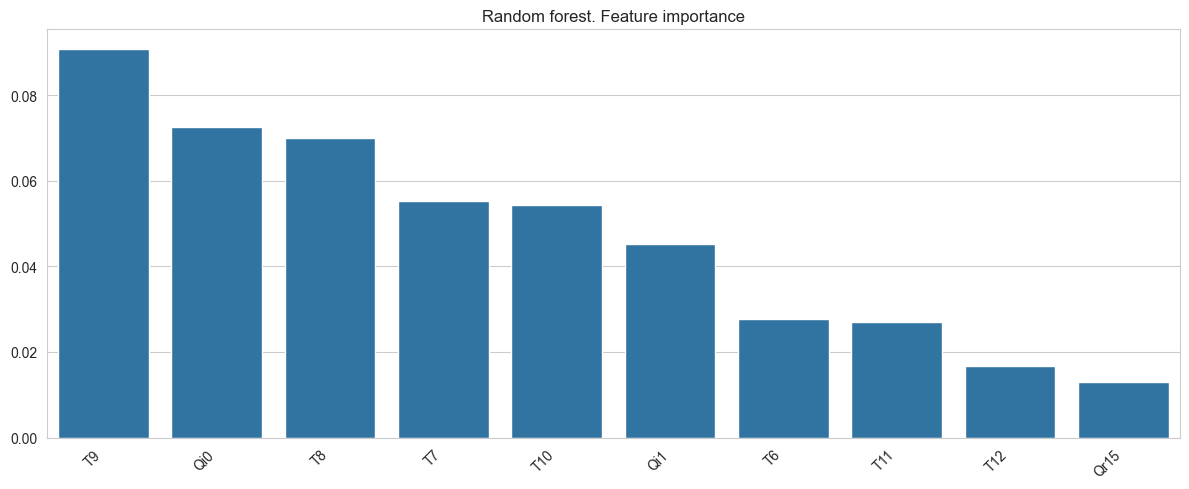

In [26]:
importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]

names = [X_train.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names[0:10], y=importances[indices[0:10]])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Random forest. Feature importance')
plt.tight_layout()

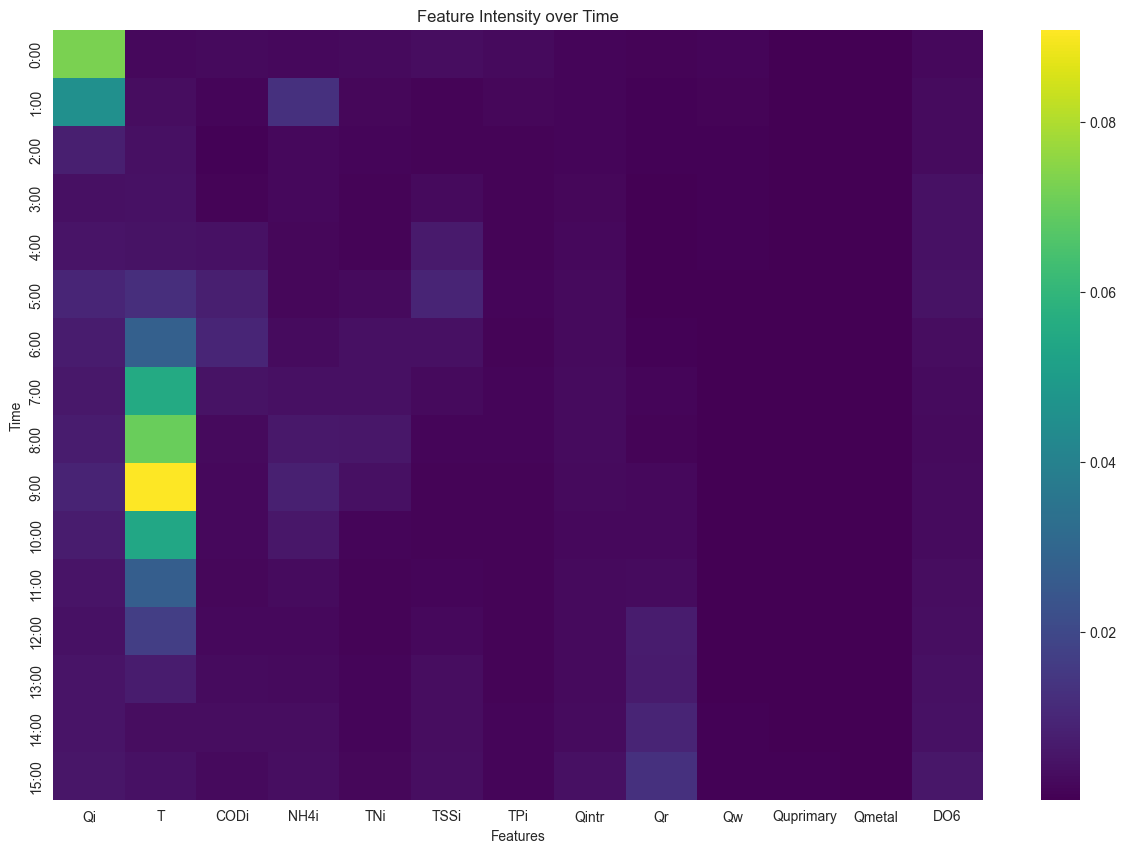

In [27]:
feature_importances = best_model.feature_importances_
data = feature_importances.reshape(16, 13, order='F')

# Create time and feature labels for the axes
time_labels = [f"{i}:00" for i in range(data.shape[0])]
feature_labels = [f"{feature}" for feature in input_variables]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

# Adding titles and labels
plt.title("Feature Intensity over Time")
plt.xlabel("Features")
plt.ylabel("Time")

# Show the plot
plt.show()

In [28]:
# Create a dictionary to hold the best lag and its importance for each variable
best_lags_rf = {}

# Extract the best lag for each variable based on feature importance
for variable in input_variables:
    best_lag = None
    max_importance = 0
    for lag in time_lags:
        importance = feature_importances[X_train.columns.get_loc(f"{variable}{lag}")]
        if importance > max_importance:
            best_lag = lag
            max_importance = importance
    best_lags_rf[variable] = {'lag': best_lag, 'importance': max_importance}

best_lags_rf

{'Qi': {'lag': 0, 'importance': 0.07261082455681839},
 'T': {'lag': 9, 'importance': 0.090805518967391},
 'CODi': {'lag': 6, 'importance': 0.009628813407096343},
 'NH4i': {'lag': 1, 'importance': 0.01286282123512778},
 'TNi': {'lag': 8, 'importance': 0.005867395315318595},
 'TSSi': {'lag': 5, 'importance': 0.009302159350024692},
 'TPi': {'lag': 0, 'importance': 0.0027722066517813816},
 'Qintr': {'lag': 15, 'importance': 0.003891306765234619},
 'Qr': {'lag': 15, 'importance': 0.013035849491144811},
 'Qw': {'lag': 0, 'importance': 0.0014287067306818187},
 'Quprimary': {'lag': 15, 'importance': 0.0008313104350278294},
 'Qmetal': {'lag': 2, 'importance': 0.0006481394651383},
 'DO6': {'lag': 15, 'importance': 0.00566486046970804}}

In [29]:
# OCI
max_depths = [30]
min_samples_leafs = [1]
min_samples_split = [2]
max_features = [0.3]
n_estimators = [500]

target_data = df_hourly['OCI'][max(time_lags):]

X_train, X_test, y_train, y_test = train_test_split(lagged_data, target_data, test_size=0.1, random_state=42)

best_oob_score = -float("inf")
best_params = {}

# Iterate over the grid
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
            for max_feature in max_features:
                for n in n_estimators:
                    for min_splits in min_samples_split:
                        model = RandomForestRegressor(
                            n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            min_samples_split=min_splits,
                            max_features=max_feature,
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1
                        )

                        model.fit(X_train, y_train)

                        if model.oob_score_ > best_oob_score:
                            best_oob_score = model.oob_score_
                            best_params = {'max_depth': max_depth,
                                           'min_samples_leaf': min_samples_leaf,
                                           'n_estimators': n,
                                           'max_features': max_feature,
                                           'min_samples_split': min_splits
                                          }

print(f"Best OOB Score: {best_oob_score}") # valid r2
print(f"Best Hyperparameters: {best_params}")

best_model_oci = RandomForestRegressor(
    **best_params,        
    random_state=42,
    n_jobs=-1 
)
best_model_oci.fit(X_train, y_train)
accuracy, mae, mse, rmse, mape, r2 = evaluate(best_model_oci, X_train, y_train)
accuracy, mae, mse, rmse, mape, r2 # train r2

Best OOB Score: 0.9563535892052826
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 500, 'max_features': 0.3, 'min_samples_split': 2}


(99.50846722941836,
 96.88402131632475,
 16283.918978757894,
 127.60845966767992,
 0.49153277058164163,
 0.9940756433650884)

In [30]:
accuracy, mae, mse, rmse, mape, r2 = evaluate(best_model_oci, X_test, y_test)
accuracy, mae, mse, rmse, mape, r2 # train r2

(98.68790018742398,
 257.3908659346603,
 113987.99511929892,
 337.62108216060636,
 1.3120998125760157,
 0.9578669321915759)

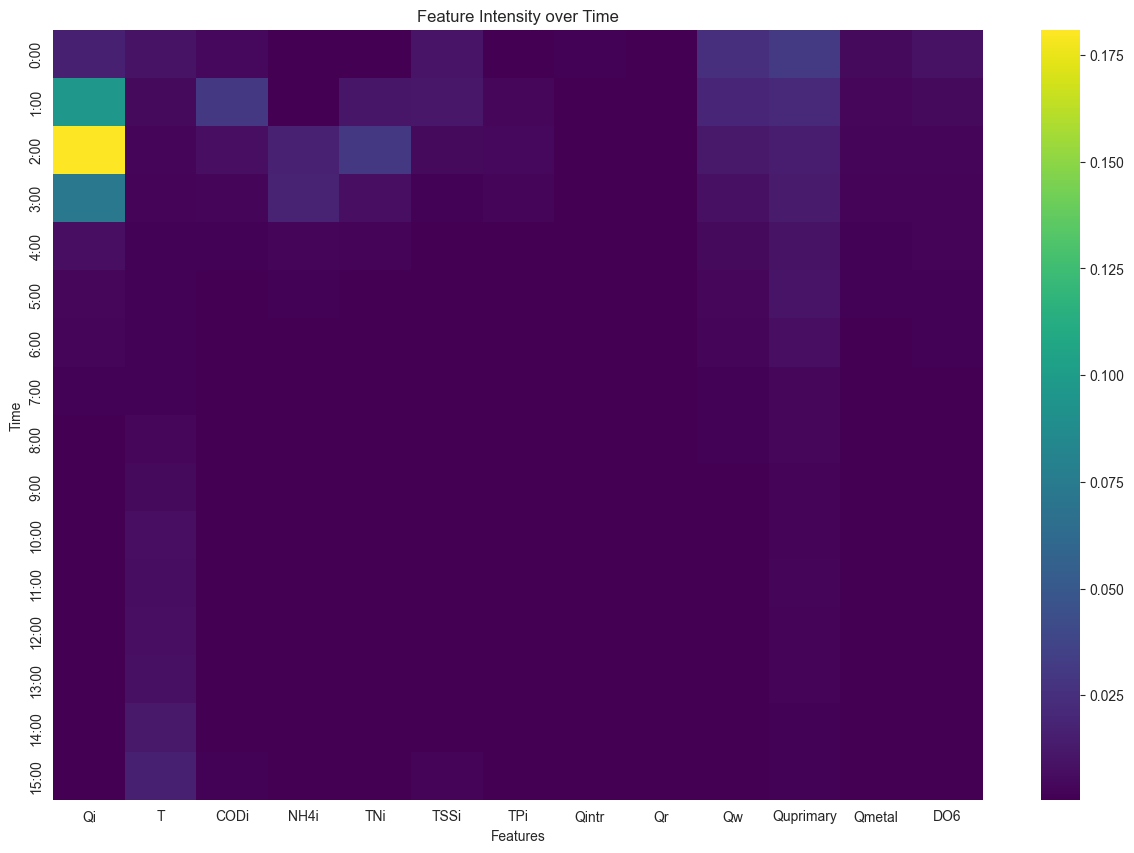

In [31]:
feature_importances = best_model_oci.feature_importances_
data = feature_importances.reshape(16, 13, order='F')

# Create time and feature labels for the axes
time_labels = [f"{i}:00" for i in range(data.shape[0])]
feature_labels = [f"{feature}" for feature in input_variables]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

# Adding titles and labels
plt.title("Feature Intensity over Time")
plt.xlabel("Features")
plt.ylabel("Time")

# Show the plot
plt.show()

In [32]:
best_lags_rf = {}

# Extract the best lag for each variable based on feature importance
for variable in input_variables:
    best_lag = None
    max_importance = 0
    for lag in time_lags:
        importance = feature_importances[X_train.columns.get_loc(f"{variable}{lag}")]
        if importance > max_importance:
            best_lag = lag
            max_importance = importance
    best_lags_rf[variable] = {'lag': best_lag, 'importance': max_importance}

best_lags_rf

{'Qi': {'lag': 2, 'importance': 0.1809222031970188},
 'T': {'lag': 15, 'importance': 0.016698376243815295},
 'CODi': {'lag': 1, 'importance': 0.029530607512737835},
 'NH4i': {'lag': 3, 'importance': 0.017981225153374542},
 'TNi': {'lag': 2, 'importance': 0.02943813136932772},
 'TSSi': {'lag': 1, 'importance': 0.011455692435052012},
 'TPi': {'lag': 2, 'importance': 0.00444601465624207},
 'Qintr': {'lag': 0, 'importance': 0.0012298795144843025},
 'Qr': {'lag': 8, 'importance': 0.0011362379490902723},
 'Qw': {'lag': 0, 'importance': 0.02504486169050965},
 'Quprimary': {'lag': 0, 'importance': 0.03044180692471517},
 'Qmetal': {'lag': 0, 'importance': 0.0054115569333600564},
 'DO6': {'lag': 0, 'importance': 0.008632456092939141}}

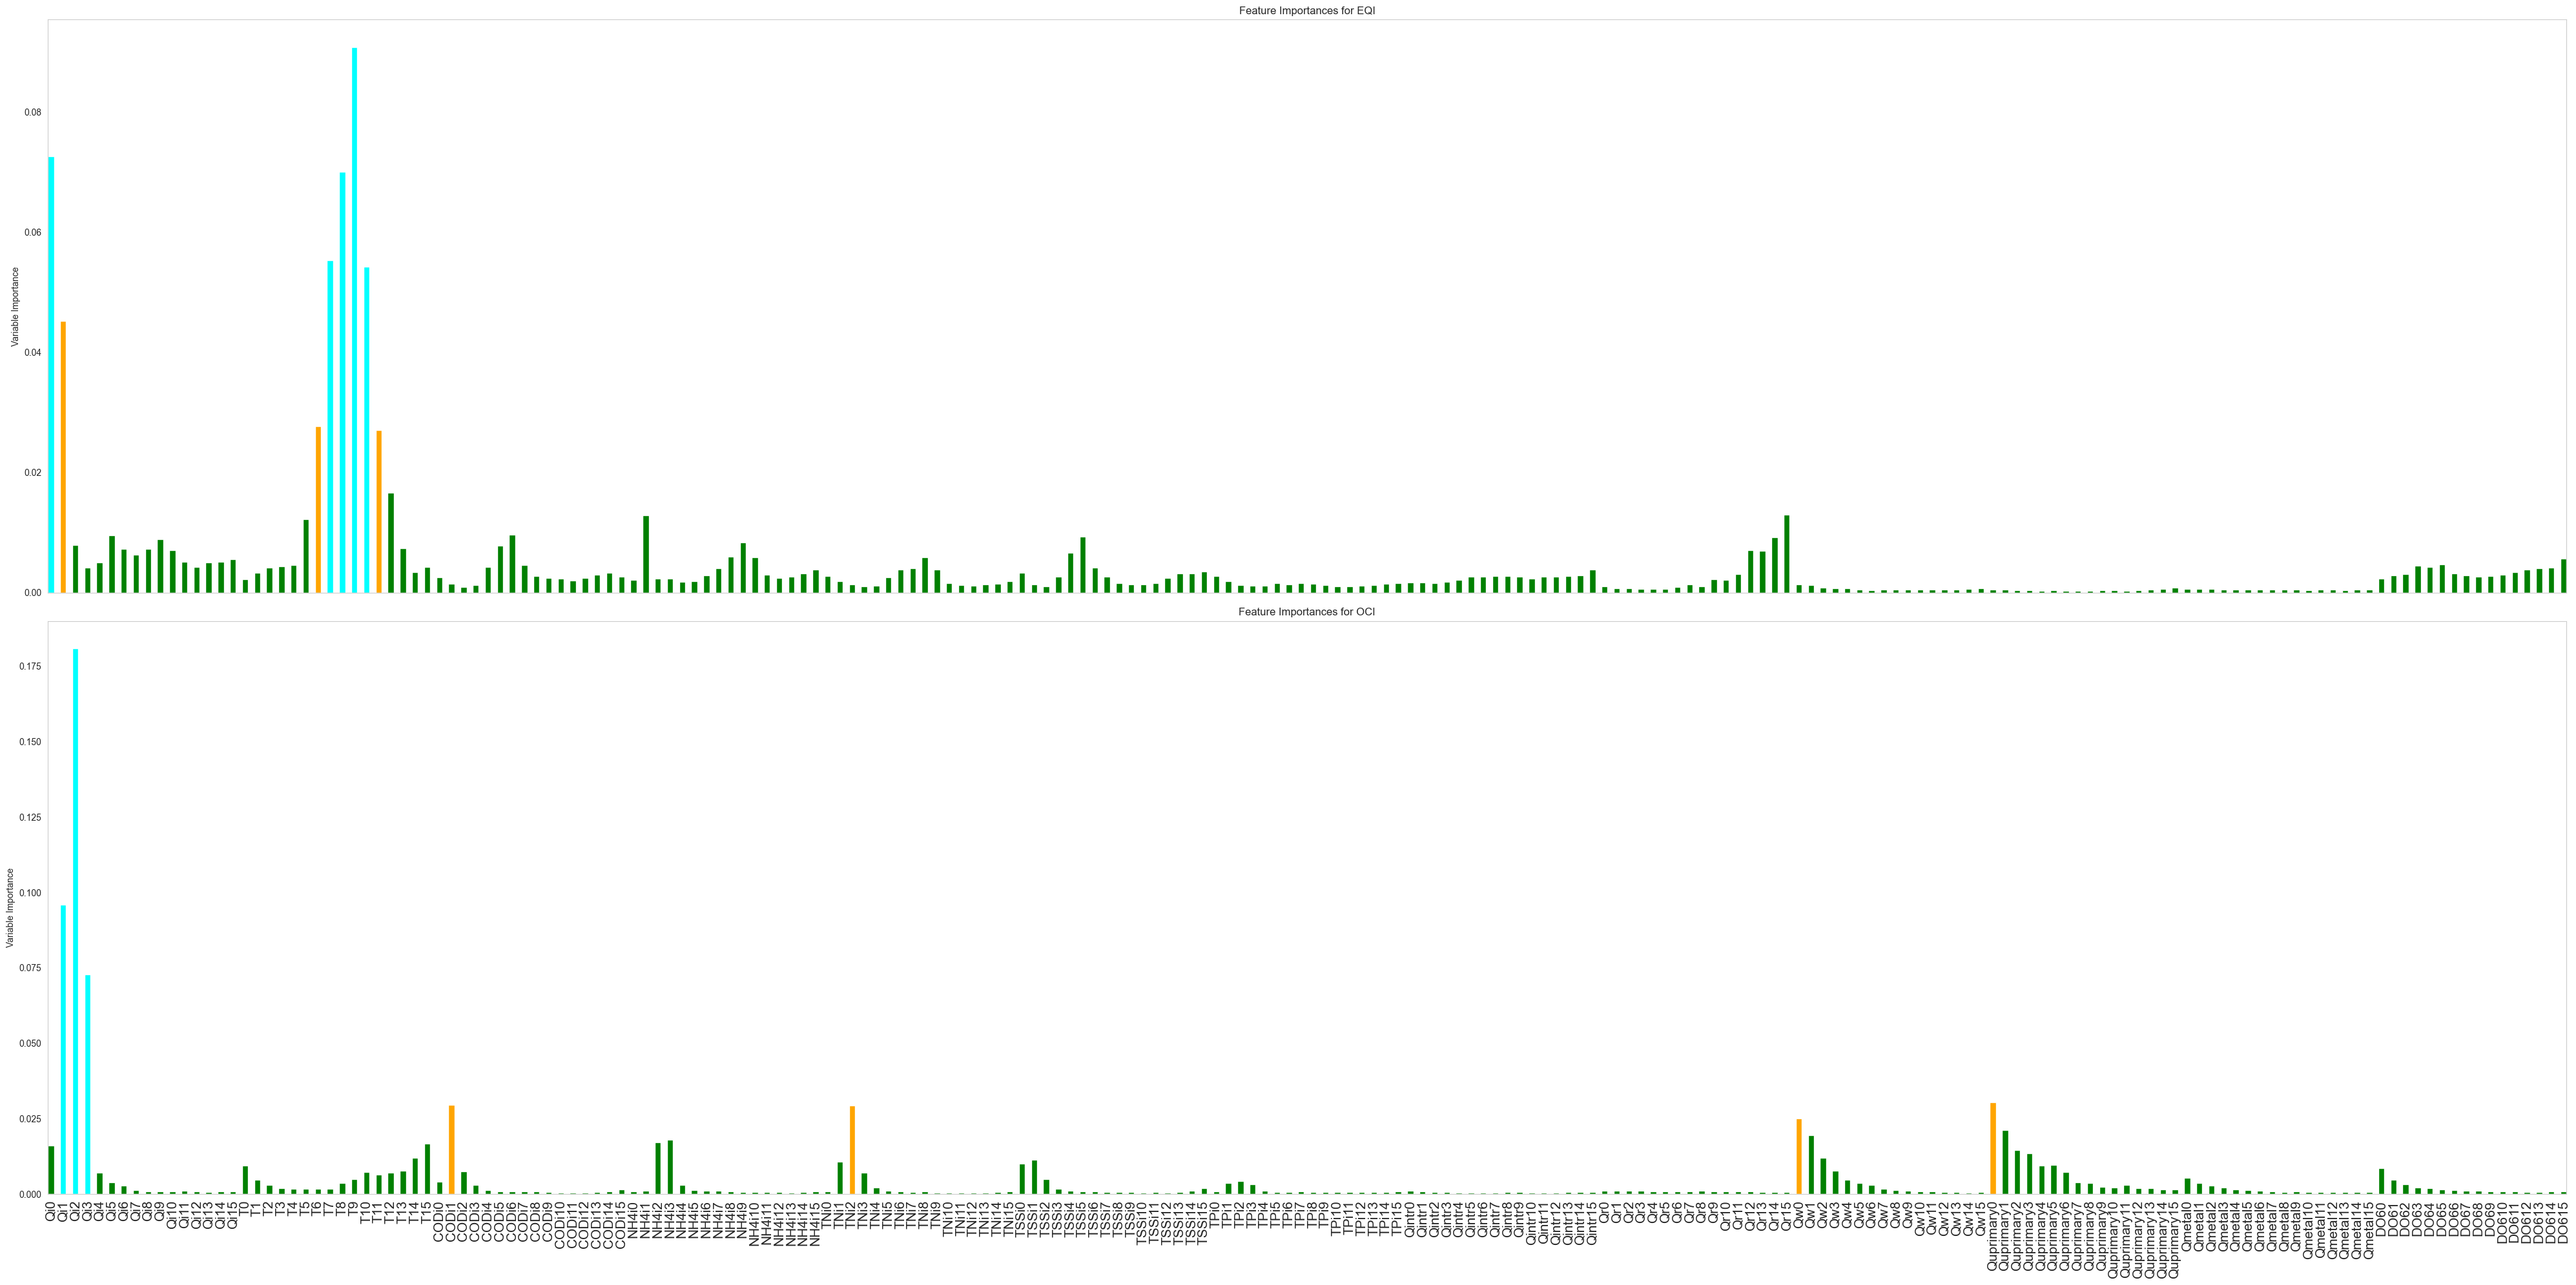

In [58]:
importances_eqi = best_model.feature_importances_
importances_oci = best_model_oci.feature_importances_

df = pd.DataFrame({
    'Feature': X_test.columns,
    'EQI': importances_eqi,
    'OCI': importances_oci
})

k = 20  # Choose top k features
top_k_eqi = df.nlargest(k, 'EQI')
top_k_oci = df.nlargest(k, 'OCI')

# Function to determine bar colors based on VIM values
def get_bar_color(vim_values):
    colors = []
    for value in vim_values:
        if value >= 0.05:
            colors.append('cyan')  # Significantly important
        elif value >= 0.025:
            colors.append('orange')  # Important
        else:
            colors.append('green')  # Least important
    return colors

eqi_colors = get_bar_color(top_k_eqi['EQI'])
oci_colors = get_bar_color(top_k_oci['OCI'])

# Set the positions of the bars
pos = np.arange(len(df['Feature']))
bar_width = 0.5  # Set the width of each bar

# Create subplots for each set of feature importances
fig, axs = plt.subplots(2, 1, figsize=(40, 20))

# Plot EQI bars
axs[0].bar(pos, df['EQI'], bar_width, label='EQI', color=eqi_colors)
axs[0].set_title('Feature Importances for EQI', fontsize=15)
axs[0].set_xticks([])  # Hide x labels for the top plot
axs[0].grid(visible=False) 

# Plot OCI bars
axs[1].bar(pos, df['OCI'], bar_width, label='OCI', color=oci_colors)
axs[1].set_title('Feature Importances for OCI', fontsize=15)
axs[1].set_xticks(pos)
axs[1].set_xticklabels(df['Feature'], rotation=90, fontsize=15)
axs[1].grid(visible=False) 

axs[0].margins(x=0)
axs[1].margins(x=0)

# Add labels, legend, and adjust layout
for ax in axs:
    ax.set_ylabel('Variable Importance', fontsize=15)
    #ax.legend()

#fig.suptitle('Comparison of Feature Importances')
plt.tight_layout()
plt.show()

# EQI SHAP

In [61]:
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_test)

shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

In [84]:
# for one prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

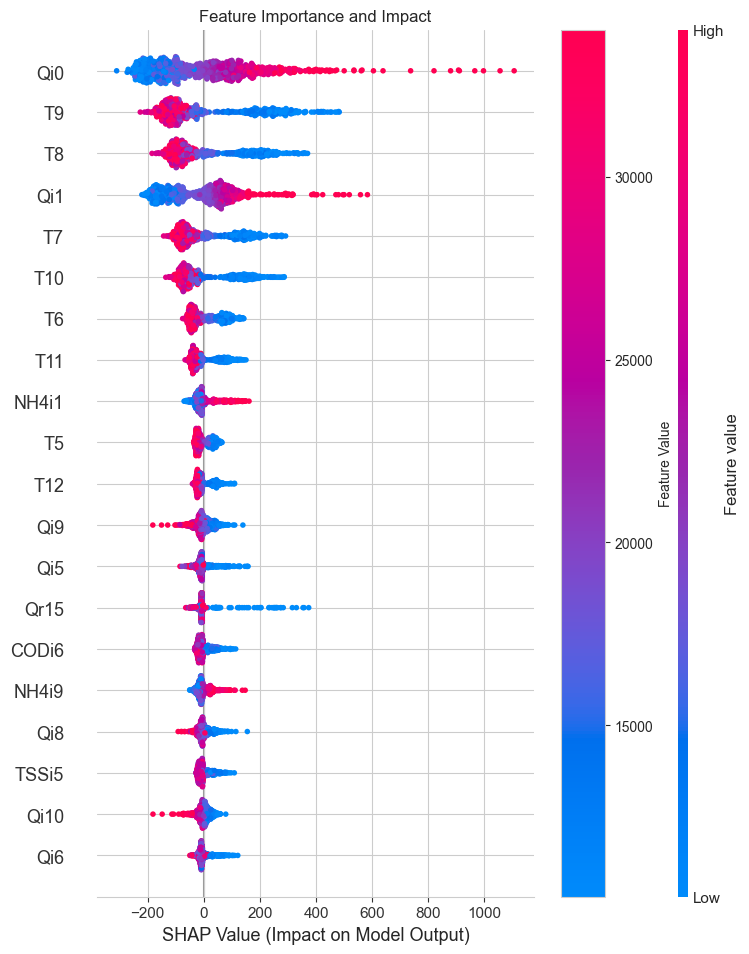

In [93]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)

plt.title('Feature Importance and Impact')
plt.xlabel('SHAP Value (Impact on Model Output)')
plt.colorbar(label='Feature Value', cmap='viridis')

plt.savefig('shap_summary_plot_eqi.png', dpi=300, bbox_inches='tight')

The SHAP summary plot visualizes the impact of top 20 features on the model's predictions. Each dot represents the SHAP value for a feature for an individual prediction. The position on the x-axis indicates the magnitude and direction of the feature's impact. Features are listed on the y-axis, ordered by the sum of SHAP value magnitudes across all samples.

The color scale on the right indicates feature value, with red representing high and blue representing low. This demonstrates not only the impact but also the direction of the relationship; for instance, a feature with high values may lead to an increase (red dots to the right) or decrease (red dots to the left) in the predicted outcome.

Key observations from this plot include:

Q10 (topmost feature) shows a high density of points to the right, indicating that higher values for this feature consistently increase the model's output.
T9 and T8 demonstrate significant variability in their impact, with SHAP values spread across both sides of the zero line. This suggests that these features can either increase or decrease the prediction depending on their value.
Some features like NH4i1 and CODi6 show clusters of high impact (in terms of SHAP value) for some predictions but not others, indicating a non-uniform influence across the dataset.
Features at the bottom of the plot, such as Qi6 and Qi10, have less impact on the model's output, as indicated by the lower absolute SHAP values.
The plot provides insight into the model's decision-making process, revealing which features are most influential and how their values affect the predictions. Such insights are invaluable for understanding the underlying mechanisms captured by the model, informing feature engineering, and guiding data collection strategies.

# OCI SHAP

In [73]:
explainer_oci = shap.Explainer(best_model_oci)
shap_values_oci = explainer.shap_values(X_test)

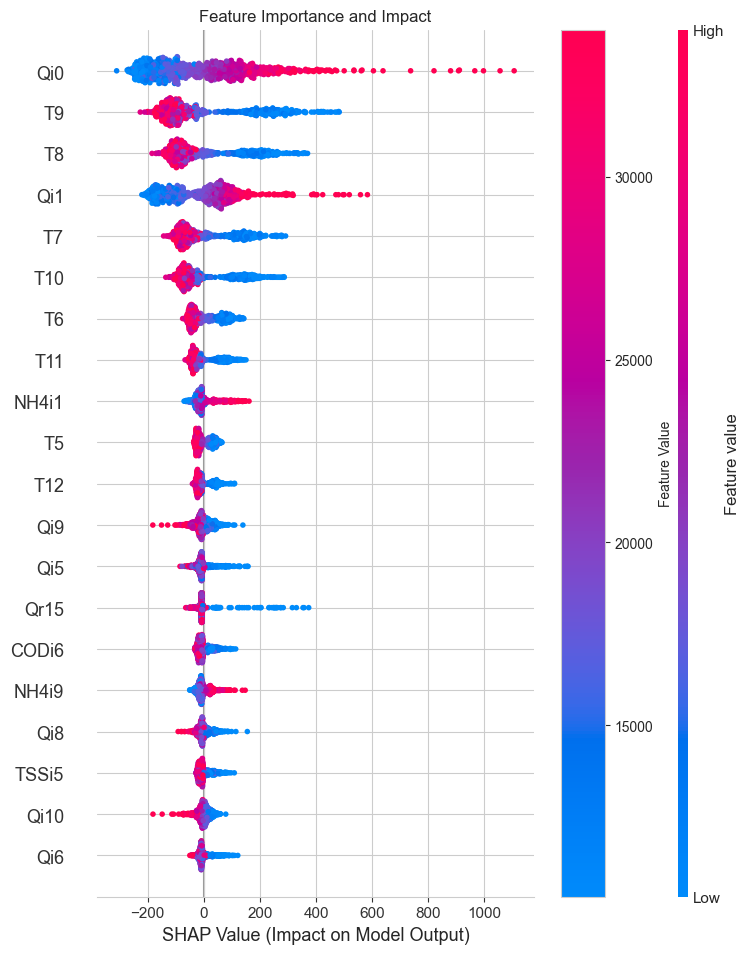

In [94]:
shap.summary_plot(shap_values_oci, X_test, plot_type="dot", show=False)

plt.title('Feature Importance and Impact')
plt.xlabel('SHAP Value (Impact on Model Output)')
plt.colorbar(label='Feature Value', cmap='viridis')

plt.savefig('shap_summary_plot_oci.png', dpi=300, bbox_inches='tight')